In [1]:
import mo_descriptor as md
import nn_frame as nn
import numpy as np
import subprocess
subprocess.run('export TF_INTRA_OP_PARALLELISM_THREADS=12', shell=True)

2022-07-29 09:07:24.706158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 09:07:24.706305: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CompletedProcess(args='export TF_INTRA_OP_PARALLELISM_THREADS=12', returncode=0)

In [2]:
'''
prepare data_set
1. make mo_pair descriptor
'''
# x_shift = np.arange(0, 4.1, 0.1)
# y_shift = np.arange(0, 4.1, 0.1)
# z_shift = np.zeros(x_shift.shape)
# # the original mo, e.g. homo
# homo = md.MO_descriptor('data/homo-s0.cube').make()
# lumo = md.MO_descriptor('data/lumo-s0.cube').make()

# # for the original pair of one mo and itself
# homo_pair = md.MO_pair_descriptor(homo, homo).make()
# lumo_pair = md.MO_pair_descriptor(lumo, lumo).make()

# # for the shifted pair
# homo_pairs = np.zeros((len(x_shift)*len(y_shift),) + homo_pair.shape)
# lumo_pairs = np.zeros((len(x_shift)*len(y_shift),) + lumo_pair.shape)
# for ii, i in enumerate(x_shift):
#     for jj, j in enumerate(y_shift):
#         idx = ii * len(y_shift) + jj
#         homo_pairs[idx][0] = homo_pair[0]
#         homo_pairs[idx][1] = np.add(homo_pair[1],i)
#         homo_pairs[idx][2] = np.add(homo_pair[2],j)
#         homo_pairs[idx][3] = homo_pair[3]
#         lumo_pairs[idx][0] = lumo_pair[0]
#         lumo_pairs[idx][1] = np.add(lumo_pair[1],i)
#         lumo_pairs[idx][2] = np.add(lumo_pair[2],j)
#         lumo_pairs[idx][3] = lumo_pair[3]
# np.save('homo_homo_pair.npy', homo_pairs)
# np.save('lumo_lumo_pair.npy', lumo_pairs)
homo_pairs = np.load('homo_homo_pair.npy')
lumo_pairs = np.load('lumo_lumo_pair.npy')

In [3]:
'''
2. read coupling
'''
raw_data = np.loadtxt('data/cdft-V1V2.dat')
c_homo = np.add(raw_data[:,2], raw_data[:,3]) * 1/2
c_lumo = np.add(raw_data[:,4], raw_data[:,5]) * 1/2

In [4]:
x1 = homo_pairs[:,0,:,:]
x2 = homo_pairs[:,1,:,:]
x3 = homo_pairs[:,2,:,:]
x4 = homo_pairs[:,3,:,:]
x = np.einsum('aij,aij,aij,aij->aij', x1, x2, x3, x4)

train_homo_pairs = x
train_lumo_pairs = lumo_pairs[0:1200]

train_c_homo = c_homo
train_c_lumo = c_lumo[0:1200]

test_homo_pairs = homo_pairs[1200:]
test_lumo_pairs = lumo_pairs[1200:]

test_c_homo = c_homo[1200:].reshape((len(c_homo[1200:]),1))
test_c_lumo = c_lumo[1200:]

In [ ]:
setting = {'activation':'tanh', 'nn_shape':(128,128,128), 'batch_size':18600, 'training_steps':30000,\
'learning_rate': 0.001, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':1000, 'drop_rate':0.5, 'save_path':'./save/model',\
'seed':1}
NN = nn.NN(setting_dict=setting)
NN.train(train_homo_pairs,train_c_homo)
# NN.test(test_homo_pairs, test_c_homo)

training step:     0, loss:  0.690523446


2.238216
(41, 41)


Text(0.5, 1.0, 'pred')

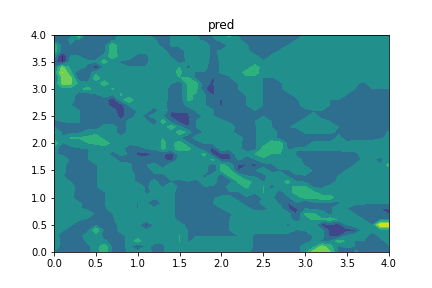

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

print(np.mean((NN.model(train_homo_pairs, training=False)-c_homo)/c_homo))
x = np.linspace(0, 4, 41)
y = np.linspace(0, 4, 41)
X, Y = np.meshgrid(x, y)
Z = NN.model(train_homo_pairs, training=False).numpy().reshape((41,41))
Z1 = c_homo.reshape((41,41))
print(Z.shape)

fix, ax = plt.subplots()
ax.contourf(x,y, Z)
ax.set_title('pred')